In [2]:
import numpy as np
from math import sqrt
import skimage.io as io
import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian
from skimage import transform
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage
from skimage.measure import ransac
import pandas as pd
from sklearn.linear_model import RANSACRegressor
import pandas as pd
from scipy import spatial
import scipy.misc as sp
from skimage.filters import gaussian
from PIL import Image
from sklearn.metrics import mean_squared_error
from cmath import inf

import matplotlib.pyplot as plt
from matplotlib import axes
from matplotlib import figure

plt.rcParams["figure.dpi"] = 300

In [3]:
from this import d

def residual_cal(src, dst):
    mse = mean_squared_error(src, dst)
    return mse

def blob_detection(img_path, min_sigma, max_sigma, threshold):
    img = io.imread(img_path)
    blob = blob_doh(img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold)
    i = 0
    # r = 3
    centers = []
    h, w = img.shape
    for blob in blob:
        y, x, r = blob
        if y > r and y < (h - r) and x > r and x < (w - r):
            centers.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r + 1), int(x - r) : int(x + r + 1)]
                )
            )
            centers[i] = list(np.add(centers[i], [x - r, y - r]))
            i += 1
    return np.array(centers)


class QuadPolyTrans(transform.PolynomialTransform):
    def estimate(*data):
        return transform.PolynomialTransform.estimate(*data, order=2)

class CubicPolyTrans(transform.PolynomialTransform):
    def estimate(*data):
        return transform.PolynomialTransform.estimate(*data, order=3)


def count_nearest_pts(src, dst, radius):
    tree = spatial.KDTree(src)
    res, idx = tree.query(dst, k=1, distance_upper_bound=radius)
    return res, idx


def save_np_img(npimg, path):
    img = Image.fromarray(npimg)
    img = img.convert("L")
    img.save(path, dpi=(300.0, 300.0))


def ploting_res(canvas_size, res, pts_radius, save_path):
    x_range, y_range = canvas_size
    pk_img = np.zeros(canvas_size)
    for ele in res:
        y = int(ele[0])
        x = int(ele[1])
        for j in range(0, pts_radius):
            for k in range(0, pts_radius):
                pk_img[
                    min(max(0, x - j), x_range - 1), min(max(0, y - k), y_range - 1)
                ] = (1024 * 2)
                pk_img[min(x_range - 1, max(0, x + j)), min(max(0, y - k), y_range - 1)] = (
                    1024 * 2
                )
                pk_img[min(x_range - 1, max(0, x + j)), min(y_range - 1, max(0, y + k))] = 1024 * 2
                pk_img[min(max(0, x - j), x_range - 1), min(y_range - 1, max(0, y + k))] = (
                    1024 * 2
                )
    blurred_img = gaussian(pk_img, sigma=3, multichannel=False)
    save_np_img(blurred_img, save_path)


def count_pairs(ref_coord, target_coord, radius):
    tree = spatial.KDTree(ref_coord)
    res, idx = tree.query(target_coord, k=1)
    polished_fretPts = ref_coord[idx[np.where(res!=inf)]]
    pairs = 0
    pp = 0
    for i in idx:
        if res[pp] < radius:
            pairs += 1
        pp += 1
    return pairs


def read_coord(csv_path):
    res_tb = pd.read_csv(csv_path)
    pts = np.column_stack((np.array(res_tb['X'][0:len(res_tb)]), np.array(res_tb['Y'][0:len(res_tb)])))
    return pts

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [4]:
res_tb = pd.read_csv('/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/Results.csv')
sample_num = int(len(res_tb) / 2)
src = np.column_stack((np.array(res_tb['XM'][0:sample_num]), np.array(res_tb['YM'][0:sample_num])))
dst = np.column_stack((np.array(res_tb['XM'][sample_num:]), np.array(res_tb['YM'][sample_num:])))

# print(src)
# print(dst)

rough_tf = transform.estimate_transform('affine', src=src, dst=dst)
# print(rough_tf(src))

movie_centers = blob_detection(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/beads_246_fret_channel.tif",
    min_sigma=1,
    max_sigma=8,
    threshold=0.0003,
)

seq_centers = blob_detection(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/min_projection_246.tif",
    min_sigma=30,
    max_sigma=500,
    threshold=0.001,
)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


## Plotting simple linear transformed beads and beads from seq image
Then we will use them to do the RANSAC test and get the reliable pairs

In [5]:
x_range = 1566
y_range = 3240
print(rough_tf(movie_centers))
print(seq_centers)
ploting_res((x_range, y_range), res=rough_tf(movie_centers), pts_radius=3, save_path='/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/movie_center.png')
ploting_res((x_range, y_range), res=seq_centers, pts_radius=3, save_path='/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/seq_center.png')

[[1132.65470094 1417.25671326]
 [ 377.94477644 1488.73310499]
 [ 524.5773712   291.92572449]
 [ 603.0611192   956.78360061]
 [2144.01280989  748.54372375]
 [2203.45685083  732.22832911]
 [1770.48660496 1124.3651037 ]
 [ 465.90929118 1408.17110193]
 [1681.7059726   644.65176164]
 [ 747.58206181 1204.70816554]
 [ 438.21136268 1276.18595132]
 [ 569.87352576 1384.44484437]
 [2789.88098501  630.74102715]
 [1068.47893637  193.36911561]]
[[2197.9787697   740.11765528]
 [1127.4978007  1418.55610052]
 [3198.97626932  183.09106788]
 [2262.5901086  1526.75789219]
 [2843.91745056  471.04683006]
 [ 529.0452616   293.48681424]
 [1933.63839764  291.62105191]
 [ 373.00775773 1489.16972781]
 [ 604.08803924  955.56752808]
 [1125.90820603  711.98627297]
 [ 627.42274552 1215.88416988]
 [2717.74955168   63.25923156]
 [1219.67818616 1199.98449675]
 [1772.83550102 1122.05673877]
 [1359.48704019 1451.88818653]
 [1587.32707361  348.42153112]
 [2373.09062172  574.76819147]
 [ 561.51287153 1480.42678684]
 [ 977.

In [6]:
res, idx = count_nearest_pts(rough_tf(movie_centers), seq_centers, 10)
print(res)
print(idx)
movie_centers = movie_centers[idx[np.where(res!=inf)]]
seq_centers = seq_centers[np.where(res!=inf)]

print(movie_centers)
print(seq_centers)

[9.6047301  5.31808493        inf        inf        inf 4.73276302
        inf 4.95628825 1.5916649         inf        inf        inf
        inf 3.29330553        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
 7.60919556        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 2.70663131        inf        inf        inf
        inf        inf]
[ 5  0 14 14 14  2 14  1  3 14 14 14 14  6 14 14 14 14 14 14 14 14 14 14
  7 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 13 14 14 14
 14 14]
[[340.79235191  98.71331805]
 [160.12285968 213.77969672]
 [ 60.11001048  25.91934784]
 [ 33.4874673  226.10227143]
 [ 72.13186358 137.0474905 ]
 [267.54359891 164.49317835]
 [ 48.37059417 212.58870355]
 [151.45341678   9.17261232]]
[[2197.9787697   740.11765528]
 [1127.4978007  1418.5

In [7]:
model, inliers = ransac(
    (movie_centers, seq_centers),
    QuadPolyTrans,
    4,
    5,
    initial_inliers=np.ones(len(movie_centers), dtype=bool),
    stop_probability=0.8,
)
print(inliers)
print(model(movie_centers))
print(seq_centers)
print(residual_cal(model(movie_centers), seq_centers))
# ploting_res((x_range, y_range), res=seq_centers, pts_radius=3, save_path='/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/selected_seq_center.png')
# ploting_res((x_range, y_range), res=model(movie_centers), pts_radius=3, save_path='/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/selected_movie_center.png')

[ True  True  True  True  True  True  True  True]
[[2199.15900588  738.57348448]
 [1129.48907312 1415.35509678]
 [ 529.97762576  293.30496077]
 [ 370.81991261 1489.15463298]
 [ 603.76885478  954.48584151]
 [1770.40809485 1125.4924769 ]
 [ 460.53292888 1407.5668458 ]
 [1065.20301832  193.07994767]]
[[2197.9787697   740.11765528]
 [1127.4978007  1418.55610052]
 [ 529.0452616   293.48681424]
 [ 373.00775773 1489.16972781]
 [ 604.08803924  955.56752808]
 [1772.83550102 1122.05673877]
 [ 458.75267142 1405.58601959]
 [1065.97876008  192.33230725]]
3.181283243661461


In [138]:
peaks_tb = pd.read_csv('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/peaks.csv')
sample_num_peaks = int(len(peaks_tb))
peak_locations = np.column_stack((np.array(peaks_tb['X'][0:sample_num_peaks]), np.array(peaks_tb['Y'][0:sample_num_peaks])))

res = model(np.array(peak_locations))

save_path = '/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0821/'
canvas_size = (1566, 3240)
ploting_res(canvas_size, res, 3, save_path + 'transformed_res.png')

[0, 0, 2, 4, 7, 11, 18, 24, 31, 38, 48, 60, 78, 89, 108, 118, 131, 143, 171, 185, 198, 211, 227, 241, 253, 266, 273, 288, 309, 324, 341, 351, 364, 383, 394, 409, 414, 427, 443, 461, 473, 483, 494, 506, 513, 521, 529, 535, 540, 546, 550, 560, 570, 575, 583, 588, 593, 595, 599, 609, 611, 614, 619, 623, 623, 625, 625, 626, 628, 630, 633, 633, 635, 639, 639, 640, 640, 640, 641, 641, 641, 643, 643, 646, 646, 647, 649, 651, 652, 652, 652, 652, 652, 653, 653, 653, 653, 653, 653, 654]
[0, 1, 2, 12, 17, 19, 28, 38, 46, 61, 77, 98, 117, 136, 158, 180, 197, 219, 240, 270, 290, 312, 331, 351, 361, 380, 400, 412, 429, 445, 459, 474, 486, 504, 511, 524, 534, 546, 561, 570, 574, 579, 582, 589, 594, 597, 600, 605, 608, 609, 611, 615, 619, 623, 625, 628, 629, 631, 636, 636, 637, 638, 638, 639, 639, 639, 642, 642, 643, 643, 643, 645, 645, 647, 648, 649, 649, 650, 650, 650, 650, 650, 652, 652, 652, 654, 654, 656, 656, 656, 656, 657, 657, 657, 658, 659, 659, 659, 660, 660]


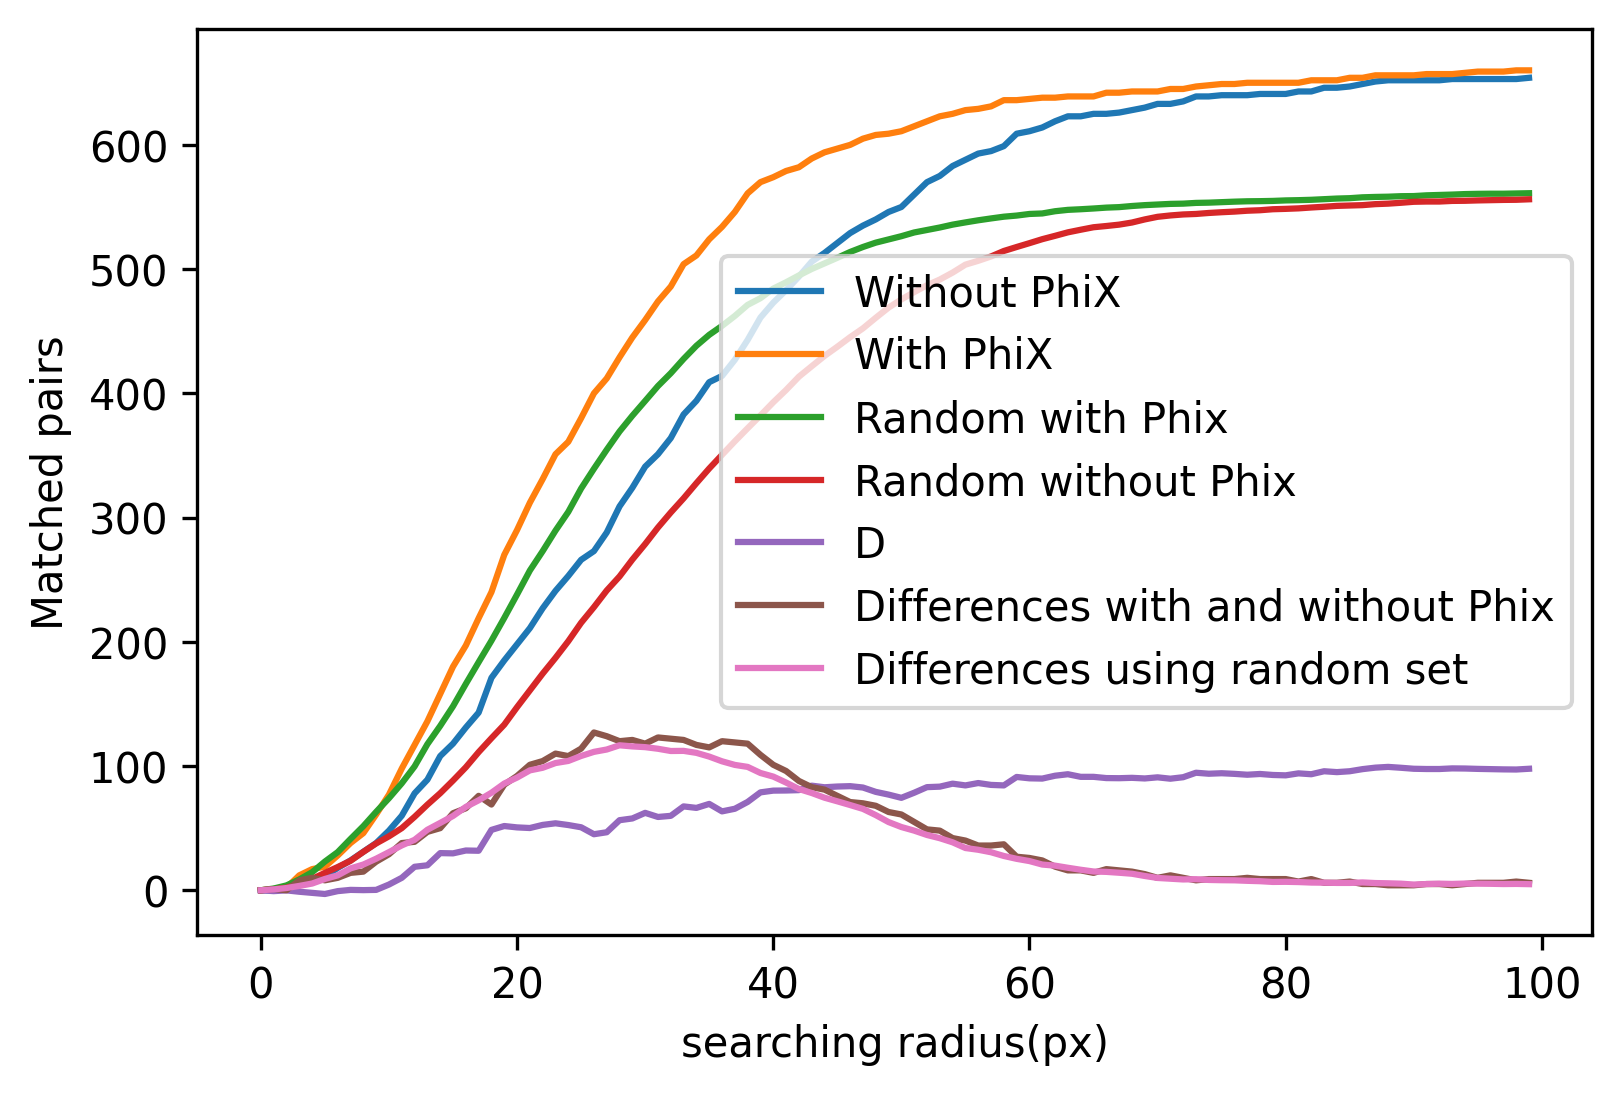

In [139]:

fastq = read_coord('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv')
fretPts = read_coord('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_fret.csv')
# poly2 = read_coord('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0808/coord_poly2.csv')
# # poly1 = read_coord('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0808/coord_nn.csv')
phix = read_coord('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_phix.csv')
# print(fastq)
pairs_lib = []
pairs_phix = []
pairs_rd_lib = []
pairs_rd_phix = []
max_radius = 100

rd_set = []
for i in range(0, 10):
    rd = np.random.random((700, 2))
    rd[:, 0] = rd[:, 0] * y_range
    rd[:, 1] = rd[:, 1] * x_range
    rd_set.append(rd)
    # print(rd)
    # ploting_res((x_range, y_range), rd, 3, save_path + 'rd1.png')


for i in range(0, max_radius):
    # print("Radius: " + str(i))
    pairs_lib.append(count_pairs(fastq, fretPts, i))
    pairs_phix.append(count_pairs(phix, fretPts, i))
    average_rd_lib = 0
    average_rd_phix = 0
    for k in range(0, len(rd_set)):
        average_rd_lib += count_pairs(fastq, rd_set[k], i)
        average_rd_phix += count_pairs(phix, rd_set[k], i)
    pairs_rd_lib.append(average_rd_lib / len(rd_set))
    pairs_rd_phix.append(average_rd_phix / len(rd_set))
    # pairs_lib_poly2.append(count_pairs(fastq, poly2, i))
    # pairs_phix_poly2.append(count_pairs(phix, poly2, i))
    # print('=====================')
print(pairs_lib)
print(pairs_phix)
# print(pairs_rd)
plt.figure()
plt.plot(range(0, max_radius), np.array(pairs_lib), label='Without PhiX')
plt.plot(range(0, max_radius), np.array(pairs_phix), label='With PhiX')
plt.plot(range(0, max_radius), np.array(pairs_rd_phix), label='Random with Phix')
plt.plot(range(0, max_radius), np.array(pairs_rd_lib), label='Random without Phix')
plt.plot(range(0, max_radius), np.array(pairs_lib) - np.array(pairs_rd_lib), label='D')
plt.plot(range(0, max_radius), np.array(pairs_phix) - np.array(pairs_lib), label='Differences with and without Phix')
plt.plot(range(0, max_radius), np.array(pairs_rd_phix) - np.array(pairs_rd_lib), label='Differences using random set')
# plt.plot(range(0, max_radius), np.array(pairs_phix) - np.array(pairs_rd), label='Difference with random')
# plt.plot(range(0, max_radius), np.array(pairs_lib_poly2), label='Poly 2 Without PhiX')
# plt.plot(range(0, max_radius), np.array(pairs_phix_poly2), label='Poly 2 With PhiX')
plt.legend()
plt.xlabel('searching radius(px)')
plt.ylabel('Matched pairs')
plt.show()

n = pairs_lib

In [127]:
ploting_res(canvas_size, fastq, 7, save_path + 'fastq.png')

In [177]:
fastq = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv")
fastq = np.concatenate((seq_centers, fastq))
fretPts = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_fret.csv")
fretPts = np.concatenate((model(movie_centers), fretPts))

# print(fastq)
# print(fretPts)

res, idx = count_nearest_pts(fretPts, fastq, 8)
# print(res)

polished_fretPts = fretPts[idx[np.where(res!=inf)]]
polished_fastq = fastq[np.where(res!=inf)]

# print(polished_fastq.shape)
# print(len(polished_fastq))
# print(len(polished_fretPts))
print(polished_fastq)
print(polished_fretPts)
print(len(polished_fastq))

ploting_res((x_range, y_range), fastq, 3, save_path=save_path + 'fastq.png')
ploting_res((x_range, y_range), fretPts, 3, save_path=save_path + 'fret.png')

[[2197.9787697   740.11765528]
 [1127.4978007  1418.55610052]
 [ 529.0452616   293.48681424]
 [ 373.00775773 1489.16972781]
 [ 604.08803924  955.56752808]
 [1772.83550102 1122.05673877]
 [ 458.75267142 1405.58601959]
 [1065.97876008  192.33230725]
 [ 535.         1499.        ]
 [1179.         1447.        ]
 [1080.         1292.        ]
 [ 773.         1270.        ]
 [1850.         1077.        ]
 [1682.         1028.        ]
 [ 456.          979.        ]
 [2354.          876.        ]
 [2099.          876.        ]
 [ 927.          845.        ]
 [1815.          839.        ]
 [1983.          793.        ]
 [2457.          646.        ]
 [ 240.          580.        ]
 [2112.          560.        ]
 [ 798.          548.        ]
 [ 556.          547.        ]
 [2089.          530.        ]
 [ 601.          522.        ]
 [1749.          497.        ]
 [1656.          481.        ]
 [1247.          438.        ]
 [ 553.          386.        ]
 [ 667.          318.        ]
 [2565. 

In [1]:
max_iter = 1
fastq = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv")
fastq = np.concatenate((seq_centers, fastq))
fretPts = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_fret.csv")
fretPts = np.concatenate((model(movie_centers), fretPts))
polished_fretPts_k = polished_fretPts
polished_fastq_k = polished_fastq

for i in range(0, max_iter):
    refined_model, inliers = ransac(
        (polished_fastq_k, polished_fretPts_k),
        CubicPolyTrans,
        int(len(polished_fastq_k) * 0.8),
        8,
        initial_inliers=np.ones(len(polished_fastq_k), dtype=bool),
        stop_probability=1,
    )
    print(inliers)
    print(fastq)
    fastq = refined_model(fastq)
    print(fastq)
    res, idx = count_nearest_pts(fretPts, fastq, 12)
    polished_fretPts_k = fretPts[idx[np.where(res!=inf)]]
    polished_fastq_k = fastq[np.where(res!=inf)]
    # print(len(polished_fastq_k))
    # print(polished_fastq_k)
    # print(fastq)
    ploting_res((x_range, y_range), polished_fastq_k, 3, save_path + 'polished_fastq_15_iter' + str(i) + '.png')
    ploting_res((x_range, y_range), polished_fretPts_k, 3, save_path + 'polished_fretPts_15_iter' + str(i) + '.png')
    ploting_res((x_range, y_range), fretPts, 3, save_path + 'fretPts_iter' + str(i) + '.png')
    ploting_res((x_range, y_range), refined_model(fastq), 3, save_path + 'refined_fastq_iter' + str(i) + '.png')
    # if i == 0:
    #     refined_model, inliers = ransac(
    #         (polished_fretPts_k, polished_fastq_k),
    #         QuadPolyTrans,
    #         int(len(polished_fastq_k) * 0.8),
    #         6,
    #         initial_inliers=np.ones(len(polished_fastq_k), dtype=bool),
    #         stop_probability=1,
    #     )
    #     fastq = refined_model(fastq)
    #     res, idx = count_nearest_pts(fretPts, fastq, 12)
    #     polished_fretPts_k = fretPts[idx[np.where(res!=inf)]]
    #     polished_fastq_k = fastq[np.where(res!=inf)]
    #     print(len(polished_fastq_k))
    #     print(polished_fastq_k)
    #     print(fastq)
    #     ploting_res((x_range, y_range), polished_fastq_k, 3, save_path + 'polished_fastq_15_iter' + str(i) + '.png')
    #     ploting_res((x_range, y_range), polished_fretPts_k, 3, save_path + 'polished_fretPts_15_iter' + str(i) + '.png')
    #     ploting_res((x_range, y_range), fretPts, 3, save_path + 'fretPts_iter' + str(i) + '.png')
    #     ploting_res((x_range, y_range), refined_model(fastq), 3, save_path + 'refined_fastq_iter' + str(i) + '.png')
    # else:
    # tform = transform.PolynomialTransform()
    # # print(polished_fretPts_k)
    # # print(polished_fastq_k)
    # tform.estimate(polished_fretPts_k, polished_fastq_k, order=1)
    # print(fastq)
    # fastq = tform(fastq)
    # print(fastq)
    # res, idx = count_nearest_pts(fretPts, fastq, 12)
    # print(idx)
    # polished_fretPts_k = fretPts[idx[np.where(res!=inf)]]
    # polished_fastq_k = fastq[np.where(res!=inf)]
    # print(len(polished_fastq_k))
    # print(polished_fastq_k)
    # ploting_res((x_range, y_range), polished_fastq_k, 3, save_path + 'polished_fastq_15_iter' + str(i) + '.png')
    # ploting_res((x_range, y_range), polished_fretPts_k, 3, save_path + 'polished_fretPts_15_iter' + str(i) + '.png')
    # ploting_res((x_range, y_range), fretPts, 3, save_path + 'fretPts_iter' + str(i) + '.png')
    # ploting_res((x_range, y_range), tform(fastq), 3, save_path + 'refined_fastq_iter' + str(i) + '.png')


NameError: name 'read_coord' is not defined

In [215]:
from tkinter import Y
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, n_feature, n_output):
        super(NeuralNetwork, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, 8)
        # self.hidden2 = torch.nn.Linear(8, 8)
        self.predict = torch.nn.Linear(8, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        # x = F.relu(self.hidden2(x))
        x = self.predict(x)
        return x

model = NeuralNetwork(n_feature=2, n_output=2).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

from math import dist

model_r, inliers = ransac(
    (movie_centers, seq_centers),
    QuadPolyTrans,
    4,
    5,
    initial_inliers=np.ones(len(movie_centers), dtype=bool),
    stop_probability=0.8,
)

fastq = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv")
fastq = np.concatenate((seq_centers, fastq))
fretPts = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_fret.csv")
fretPts = np.concatenate((model_r(movie_centers), fretPts))
res, idx = count_nearest_pts(fretPts, fastq, 8)
# print(res)

polished_fretPts = fretPts[idx[np.where(res!=inf)]]
polished_fastq = fastq[np.where(res!=inf)]
polished_fretPts_v = torch.from_numpy(polished_fretPts.astype(np.float32))
polished_fastq_v = torch.from_numpy(polished_fastq.astype(np.float32))
# print(np.array(res_tb['Y'][0:sample_num]))
# print(np.column_stack((np.array(res_tb['Y'][0:sample_num]), np.array(res_tb['X'][0:sample_num]))))

# src = np.column_stack((np.array(res_tb['Y'][0:sample_num]), np.array(res_tb['X'][0:sample_num])))
# src_v = torch.from_numpy(src.astype(np.float32))
# dst = np.column_stack((np.array(res_tb['Y'][sample_num:]), np.array(res_tb['X'][sample_num:])))
# dst_v = torch.from_numpy(dst.astype(np.float32))


for t in range(10000):
    prediction = model(polished_fastq_v)
    loss = loss_fn(prediction, polished_fretPts_v)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(model(torch.from_numpy(fastq.astype(np.float32))))
print(fretPts)

fastq = model((torch.from_numpy(fastq.astype(np.float32)))).cpu().detach().numpy()

res, idx = count_nearest_pts(fretPts, fastq, 12)
polished_fretPts_k = fretPts[idx[np.where(res!=inf)]]
polished_fastq_k = fastq[np.where(res!=inf)]
# print(len(polished_fastq_k))
# print(polished_fastq_k)
# print(fastq)
ploting_res((x_range, y_range), polished_fastq_k, 3, save_path + 'polished_fastq_nn' + str(i) + '.png')
ploting_res((x_range, y_range), polished_fretPts_k, 3, save_path + 'polished_fretPts_nn' + str(i) + '.png')
ploting_res((x_range, y_range), fretPts, 3, save_path + 'fretPts_nn' + str(i) + '.png')
ploting_res((x_range, y_range), fastq, 3, save_path + 'refined_fastq_nn' + str(i) + '.png')


Using cpu device
tensor([[2197.3979,  741.3675],
        [1128.4111, 1417.9937],
        [ 531.0628,  291.2327],
        ...,
        [2730.3730,   13.1620],
        [2363.9683,   11.0814],
        [1524.3326,    7.6011]], grad_fn=<AddmmBackward0>)
[[2199.15900588  738.57348448]
 [1129.48907312 1415.35509678]
 [ 529.97762576  293.30496077]
 ...
 [1397.          181.        ]
 [1232.          180.        ]
 [1521.          176.        ]]
